In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:>

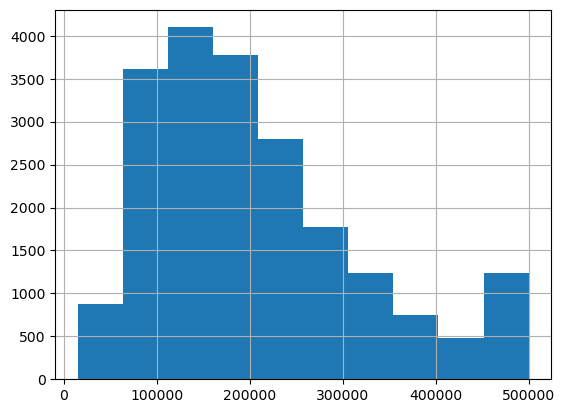

In [4]:
df['median_house_value'].hist()


In [6]:
df = df[['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [7]:
df['total_bedrooms'].isna().sum()


207

In [8]:
df['population'].median()


1166.0

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

len(df_train), len(df_val), len(df_test)


y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)


In [11]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [12]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)
df_test = df_test.fillna(0)

In [13]:
from sklearn.linear_model import LinearRegression

def train_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model


In [14]:
df_train.head()


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17244,34.43,-119.67,39.0,1467.0,381.0,1404.0,374.0,2.3681
8817,33.74,-118.32,24.0,6097.0,794.0,2248.0,806.0,10.1357
19686,39.13,-121.62,41.0,1317.0,309.0,856.0,337.0,1.6719
3545,34.24,-118.63,9.0,4759.0,924.0,1884.0,915.0,4.8333
17019,37.52,-122.30,38.0,2769.0,387.0,994.0,395.0,5.5902


In [15]:
train_matrix = df_train.values
val_matrix = df_val.values

In [16]:
model = train_linear_regression(train_matrix, y_train)

In [17]:
y_pred = model.predict(val_matrix)


In [18]:
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

rmse(y_val, y_pred)


0.3392326250444735

In [19]:
model.coef_


array([-2.81800422e-01, -2.77862345e-01,  3.34601160e-03, -3.34003869e-05,
        5.07679742e-04, -1.72512852e-04,  2.41531761e-04,  1.80175561e-01])

In [27]:
from sklearn.model_selection import KFold

def train_linear_regression_reg(X, y, r=0.001):
    model = LinearRegression()
    model.fit(X, y)
    return model

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def train(df_train, y_train, r=0.001):
    df_train = df_train.fillna(0)
    train_matrix = df_train.values
    model = train_linear_regression_reg(train_matrix, y_train, r=r)
    return model

def predict(df, model):
    df = df.fillna(0)
    X = df.values
    y_pred = model.predict(X)
    return y_pred

def evaluate(df_val, y_val, model):
    y_pred = predict(df_val, model)
    return rmse(y_val, y_pred)

def cross_validate(k, df_train, y_train, r=0.001):
    # data
    df_full_train = pd.concat([df_train, df_val])
    y_full_train = np.concatenate([y_train, y_val])
    # kfold
    scores = []
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        y_train = y_full_train[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_val = y_full_train[val_idx]
        model = train(df_train, y_train, r=r)
        score = evaluate(df_val, y_val, model)
        scores.append(score)
    return scores

scores = cross_validate(10, df_train, y_train, r=0.001)
np.std(scores)


UnboundLocalError: local variable 'df_val' referenced before assignment

In [26]:
rm = 0.3392326250444735
np.std(rm)

0.0